# Performance of CMA-ES dependent on various scaling

## Various scalings

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt

import tengp
import numpy as np
from gpbenchmarks import get_data
from sklearn.metrics import mean_squared_error
import random


In [1]:
def scale_a(x, a, b):
    return a + (b - a) * x / 10

def scale_b(x, a, b):
    return a + (b - a) * (x/10)**2

def scale_c(x, a, b):
    return a *(b/a)**(x/10)

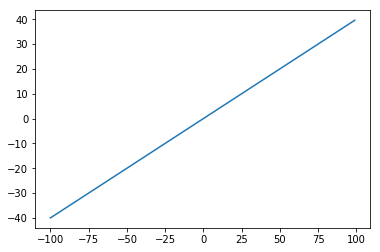

In [39]:
X = range(-100, 100)
y = [scale_a(x, 0, 4) for x in X]
plt.plot(X, y)

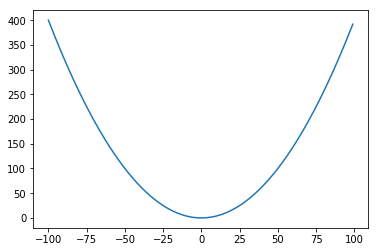

In [38]:
X = range(-100, 100)
y = [scale_b(x, 0, 4) for x in X]
plt.plot(X, y)

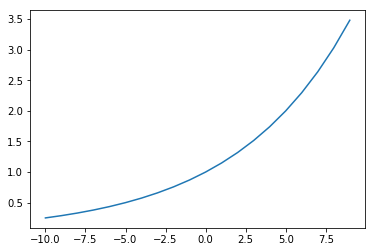

In [45]:
X = range(-10, 10)
y = [scale_c(x, 1, 4) for x in X]
plt.plot(X, y)

## Boundary handling

In [145]:
import math

def bound(x, a, b):
    return a + (b - a) * ( 1 - np.cos(np.pi * x/10))/2

In [47]:
X = range(-20, 20)
y = [bound(x, 0, 10) for x in X]

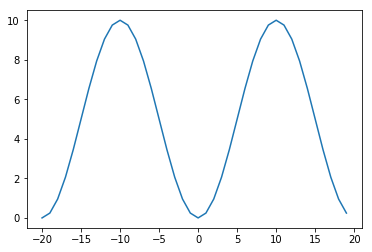

In [49]:
plt.plot(X, y)

## RV-CGP system

In [178]:
def pdivide(x, y):
    return np.divide(x, y, out=np.copy(x), where=x!=0)

def plog(x, _):
    return np.log(x, out=np.copy(x), where=x>0)

def psin(x, _):
    return np.sin(x)

def pcos(x, _):
    return np.cos(x)

def pow2(x):
    return x**2

def pow3(x):
    return x**3


funset = tengp.FunctionSet()
funset.add(np.add, 2)
funset.add(np.subtract, 2)
funset.add(np.multiply, 2)
funset.add(pdivide, 2)

X, y = get_data('nguyenf4', 20, -1, 1)
X = np.c_[np.ones(len(X)), X]

params = tengp.Parameters(2, 1, 1, 10, funset, real_valued=True)

builder = tengp.individual.IndividualBuilder(params)
bounds = builder.create().bounds[:]
individuals = []

# define cost function (first scale, then bound)

In [184]:
def cost_function(rv_genes):
    bounded = bound(np.array(rv_genes), 0, 10)
    scaled = [scale_b(x, 0, b) for x, b in zip(bounded, bounds)]
    
    individual = tengp.individual.NPIndividual(scaled, bounds, params)
    pred = individual.transform(X)
    
    try:
        out = mean_squared_error(pred, y)
    except ValueError:
        out = np.inf
    return (out, )

In [166]:
centroid = [random.uniform(0, 10) for _ in  bounds]

In [152]:
from array import array
from deap import creator, base, tools, cma, algorithms

creator.create('FitnessMin', base.Fitness, weights=(-1.0,))
creator.create('Individual', array, typecode='f', fitness=creator.FitnessMin)

/home/jarino/anaconda3/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/jarino/anaconda3/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


In [167]:
def run_strategy(cost_function, centroid, sigma):
    
    strategy = cma.Strategy(centroid=centroid, sigma=sigma)

    toolbox = base.Toolbox()
    toolbox.register('evaluate', cost_function)
    toolbox.register("generate", strategy.generate, creator.Individual)
    toolbox.register("update", strategy.update)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("min", np.min)

    pop, log = algorithms.eaGenerateUpdate(toolbox, ngen=250, stats=stats, halloffame=hof, verbose=True)
    
    return hof[0]

In [170]:
best = run_strategy(cost_function, centroid, 0.05)
print(cost_function(best))

gen	nevals	avg    	min    
0  	14    	2.10196	2.09835
1  	14    	2.10148	2.09835
2  	14    	2.10119	2.09824
3  	14    	2.10051	2.09831
4  	14    	2.0992 	2.09824
5  	14    	2.09887	2.09824
6  	14    	2.09943	2.09824
7  	14    	2.1009 	2.09824
8  	14    	2.10021	2.09824
9  	14    	2.10108	2.09824
10 	14    	2.10141	2.09828
11 	14    	2.10151	2.09825
12 	14    	2.09977	2.09825
13 	14    	2.10057	2.09824
14 	14    	2.1009 	2.09845
15 	14    	2.10004	2.09824
16 	14    	2.10003	2.09825
17 	14    	2.10028	2.09824
18 	14    	2.10062	2.09826
19 	14    	2.10023	2.09826
20 	14    	2.10073	2.09824
21 	14    	2.09951	2.09828
22 	14    	2.09987	2.09824
23 	14    	2.10071	2.09824
24 	14    	2.09953	2.09824
25 	14    	2.10157	2.09824
26 	14    	2.10195	2.09848
27 	14    	2.10061	2.09824
28 	14    	2.10143	2.09831
29 	14    	2.10041	2.09825
30 	14    	2.09997	2.09825
31 	14    	2.09981	2.09824
32 	14    	2.10001	2.09827
33 	14    	2.0994 	2.09825
34 	14    	2.10038	2.09824
35 	14    	2.09996	2.09841
3

This indicates, that there is a strong local minimum:

In [177]:
local_minimum = centroid
print(centroid,end='\n\n')
print(best)

[6.555497878962031, 0.26451617078901646, 0.11974809845908818, 9.161141186879528, 8.316612009127027, 6.508164379752874, 4.075942342663717, 5.974905132291065, 8.967468076224849, 1.3773068593510818, 4.985593172016313, 4.443865296848153, 3.892361237508297, 0.6295927834338855, 0.20970191849911113, 3.913331983599615, 1.0944306679042948, 3.31267718534047, 4.024128621634056, 9.196204660229725, 7.751246143264138, 6.046786750153902, 8.325192037734155, 1.441048552885571, 2.8350062922893002, 7.8921236401752335, 3.0287855013695753, 1.8234203174430808, 1.1746962793813043, 8.313023184358645, 1.7001463093593905]

array('f', [17.137195587158203, -9.056331634521484, 0.1991318315267563, 6.65018892288208, 10.143774032592773, 8.847066879272461, 21.055936813354492, 17.140697479248047, 4.874202251434326, 4.454037666320801, 26.03368377685547, -5.769693374633789, -20.817428588867188, -5.52223539352417, -3.0488827228546143, 2.043699026107788, 3.4036643505096436, 2.3650851249694824, 11.266404151916504, 6.8114333

In [176]:
best = run_strategy(cost_function, centroid, 2)
print(cost_function(best))

gen	nevals	avg        	min    
0  	14    	1.82944e+08	2.11045
1  	14    	8.16857e+08	2.29657
2  	14    	2.3019e+06 	2.11338
3  	14    	33429.7    	2.1812 
4  	14    	81974.7    	2.12378
5  	14    	790.974    	2.12111
6  	14    	7140.5     	2.10903
7  	14    	613198     	2.17262
8  	14    	1.81438e+07	2.14026
9  	14    	36667.9    	2.12942
10 	14    	187576     	2.11673
11 	14    	1.49366e+06	1.69843
12 	14    	1.65301e+09	2.1509 
13 	14    	2.81307e+07	1.98473
14 	14    	2663.1     	2.09927
15 	14    	3.79932e+07	2.11328
16 	14    	5022.53    	1.67096
17 	14    	7457.69    	2.10009
18 	14    	2.3388e+07 	1.27458
19 	14    	653893     	2.12547
20 	14    	2219.47    	2.10144
21 	14    	13127.1    	2.1044 
22 	14    	1.15239e+08	2.10324
23 	14    	272.364    	1.15337
24 	14    	52.288     	1.06404
25 	14    	29776.8    	2.16599
26 	14    	396.424    	1.59868
27 	14    	1.17467e+06	2.10797
28 	14    	3.78574    	2.10039
29 	14    	389.975    	2.13752
30 	14    	134.221    	2.10647
31 	14  

## larger individual (20 nodes)

In [179]:
params = tengp.Parameters(2, 1, 1, 20, funset, real_valued=True)

builder = tengp.individual.IndividualBuilder(params)
bounds = builder.create().bounds[:]

centroid = [random.uniform(0, 10) for _ in  bounds]

In [191]:
run_strategy(cost_function, centroid, 0.1)

gen	nevals	avg        	min    
0  	16    	1.44751e+06	3.41479
1  	16    	6396.76    	3.40889
2  	16    	3.42801    	3.22021
3  	16    	3.14244    	2.76633
4  	16    	3.11617    	2.5796 
5  	16    	2.9071     	2.64214
6  	16    	4594       	2.58979
7  	16    	1253.33    	2.51067
8  	16    	2.72707    	2.43129
9  	16    	2.55524    	2.39794
10 	16    	2.46587    	2.3637 
11 	16    	2.41031    	2.30406
12 	16    	2.88056    	2.27231
13 	16    	2.60026    	2.25328
14 	16    	2.97398    	2.27053
15 	16    	2.33297    	2.22065
16 	16    	2.79613    	2.19747
17 	16    	2.43663    	2.14106
18 	16    	2.22167    	2.07614
19 	16    	2.98457    	2.00264
20 	16    	2.74433    	2.09984
21 	16    	2.53143    	2.01544
22 	16    	3.00352    	1.92076
23 	16    	2.37231    	1.95178
24 	16    	3.00375    	1.99881
25 	16    	2.08765    	1.9918 
26 	16    	2.55771    	1.93818
27 	16    	2.70493    	1.7626 
28 	16    	2.60648    	1.73318
29 	16    	2.26665    	1.76832
30 	16    	2.56103    	1.82285
31 	16  

array('f', [7.1999711990356445, 6.320977210998535, 6.6705121994018555, 5.508570671081543, 10.202159881591797, 2.262824058532715, 7.040029525756836, 1.110470175743103, 6.270707607269287, 5.750834941864014, 1.7816388607025146, 7.929802417755127, 8.007181167602539, 4.529876232147217, 6.2843217849731445, 1.6046366691589355, 0.1066577136516571, 6.646388053894043, 7.341962814331055, 6.705615520477295, 8.942651748657227, 4.166326522827148, 3.6867940425872803, 2.6279125213623047, 1.5423667430877686, 6.590963840484619, 8.59367847442627, 7.058895587921143, 2.818267583847046, 4.52976655960083, 4.897297382354736, 9.1488037109375, 0.6477195024490356, 2.4561831951141357, 4.610124111175537, 6.279303073883057, 4.717519760131836, 7.7361345291137695, 3.2247371673583984, 4.490237712860107, 3.4118034839630127, 5.806270122528076, 2.6611998081207275, 1.6611407995224, 1.3109534978866577, 3.6013612747192383, 5.9259419441223145, 2.4869954586029053, 3.270754098892212, 8.576342582702637, -0.03354218602180481, 7.